# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

More specifically, the questions to be answered:

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import classification_report, roc_curve

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer                    
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import reduce_sum, square, py_function, double
from tensorflow.keras.metrics import AUC, BinaryAccuracy, TrueNegatives, TruePositives
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.math import confusion_matrix
from sklearn.utils import class_weight


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/reviews_Model.csv')

In [ ]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,neg_score,neu_score,pos_score,compound_score,language,month,dayofweek,hour,minute,text_len,word_count,category
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,order come early product good,good,order product,come,NaN,0.0,0.707,0.293,0.4404,en,9,3,20,26,47,8,Delivery
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,0.0,0.408,0.592,0.4404,en,9,3,20,13,19,3,Convenient App
2,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purc...,purchase experience happy purchase thks,first happy,purchase experience purchase,NaN,NaN,0.0,0.714,0.286,0.3400,en,9,3,20,11,57,7,Consumer Satisfaction
3,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot item good deal,good,lot item deal,NaN,NaN,0.0,0.715,0.285,0.4927,en,9,3,20,8,35,9,Variety & Price
4,5,2020-09-16 19:37:21,shoppee,google,Delivery is fast,delivery fast,fast,delivery,NaN,NaN,0.0,1.000,0.000,0.0000,en,9,3,19,37,16,3,Delivery


In [ ]:
#list comprehension for target variable
df['rate'] = [1  if (df['rating'][i] > 3) else 0 for i in range(len(df['rating']))]

In [ ]:
df['rate'].value_counts(normalize = True)

1    0.775824
0    0.224176
Name: rate, dtype: float64

In [ ]:
#Checking null values
df.isna().sum()[df.isna().sum() > 0]

adj       9807
noun     10329
verb     17904
emoji    53732
dtype: int64

In [ ]:
## Removing null values
df= df[df['clean_content'].notna()]
df.reset_index(drop = True, inplace = True)
print(f'Null values left in df: {df.clean_content.isna().sum()}')
print(f'Number of rows left: {df.shape[0]}')

Null values left in df: 0
Number of rows left: 57486


## Train Test Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], 
                                                    df['rate'], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['rate'])

In [ ]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 45988, X_test rows: 11498
y_train rows: 45988, y_test rows: 11498


## Convolutional Neural Network

In [ ]:
neg, pos = np.bincount(df['rate'])
total = neg + pos
print('Total: {}\nPositive: {} ({:.2f}% of total)\nNegative: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total, neg, 100 * neg / total))

Total: 57486
Positive: 44599 (77.58% of total)
Negative: 12887 (22.42% of total)



### Tokenize Features

In [ ]:
tokenizer = Tokenizer(num_words=9000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 9000

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

embedding_dim = 50

### Adding Sequence for Network

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Conv1D(50, 16, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(50, activation='relu', 
                    kernel_regularizer = l1_l2(l1=0.3, l2=0.3),
                    bias_regularizer = l2(0.5), 
                    activity_regularizer = l2(1)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[BinaryAccuracy(name='accuracy'), AUC(name = 'auc'), TrueNegatives(name = 'TN'), TruePositives(name = 'TP')])

### Network Summary

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9000, 50)          723400    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8985, 50)          40050     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### Training Neural Network

In [ ]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)

In [ ]:
weights = dict(enumerate(weights))
weights

{0: 2.230478222912019, 1: 0.644468735110289}

In [ ]:
model.fit(X_train, y_train, 
          epochs=100, validation_data= (X_test, y_test),
          verbose=1,
          class_weight = weights,
          callbacks=[EarlyStopping(monitor='val_auc', patience=5, min_delta=0.0001, 
                                   mode = 'max', restore_best_weights= True)])

Epoch 1/100
1438/1438 [==============================] - 83s 58ms/step - loss: 6.8334 - accuracy: 0.5609 - auc: 0.5628 - TN: 5025.0000 - TP: 20771.0000 - val_loss: 0.7815 - val_accuracy: 0.2242 - val_auc: 0.5000 - val_TN: 2578.0000 - val_TP: 0.0000e+00
Epoch 2/100
1438/1438 [==============================] - 83s 58ms/step - loss: 0.7803 - accuracy: 0.4813 - auc: 0.4986 - TN: 5542.0000 - TP: 16591.0000 - val_loss: 0.7807 - val_accuracy: 0.2242 - val_auc: 0.5000 - val_TN: 2578.0000 - val_TP: 0.0000e+00
Epoch 3/100
1438/1438 [==============================] - 83s 57ms/step - loss: 0.7593 - accuracy: 0.5691 - auc: 0.6735 - TN: 6820.0000 - TP: 19353.0000 - val_loss: 0.6599 - val_accuracy: 0.8890 - val_auc: 0.9565 - val_TN: 2330.0000 - val_TP: 7892.0000
Epoch 4/100
1438/1438 [==============================] - 83s 58ms/step - loss: 0.5598 - accuracy: 0.9009 - auc: 0.9546 - TN: 9225.0000 - TP: 32205.0000 - val_loss: 0.5208 - val_accuracy: 0.9152 - val_auc: 0.9618 - val_TN: 2239.0000 - val_TP: 

### Accuracy of Network

In [ ]:
# evaluate
predictions = (model.predict(X_test) > 0.5).astype("int32")

loss, acc, auc, tn, tp = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))
print('Test AUC: %f' % (auc))
print(f'MCC Score: {matthews_corrcoef(y_test, predictions)}')

Test Accuracy: 91.520262
Test AUC: 0.961764
MCC Score: 0.7677932523965268


### Heatmap of Neural Network

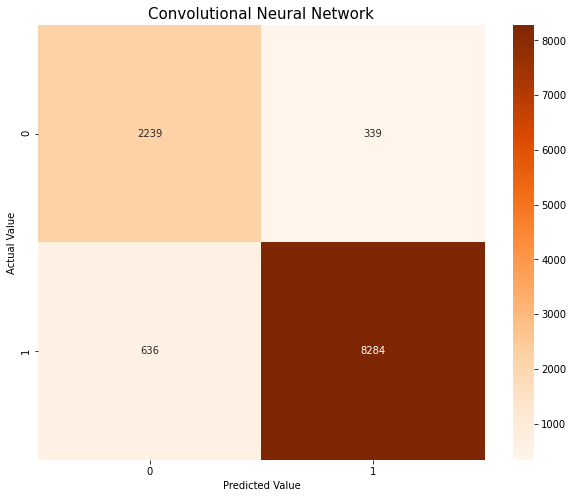

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Convolutional Neural Network', fontdict = {'fontsize': 15})
ax = sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt="d", cmap='Oranges')
ax.set_ylabel('Actual Value')
ax.set_xlabel('Predicted Value');

### Plotting ROC AUC Curve

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

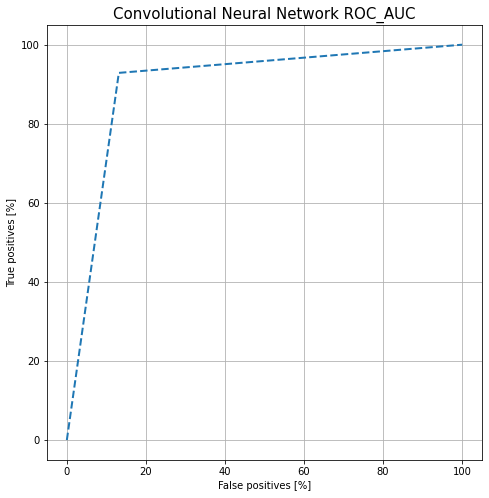

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('Convolutional Neural Network ROC_AUC', fontdict = {'fontsize': 15})
plot_roc("Test Baseline", y_test, predictions, linestyle='--')

### Check Misclassified Posts

In [ ]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(predictions, columns=['predicted'], index = y_test.index)

# Create column for observed values.
results['actual'] = y_test
results['review'] = df['review']
results['clean_content'] = df['clean_content']

# Find all indices where predicted and true results 
# aren't the same, then save in an array.
ms_class = results[results['predicted']!= results['actual']]
ms_class.head(10)

,predicted,actual,review,clean_content
4908,0,1,"First trial, seems ok.",trial ok
6241,0,1,"Sometimes for no reason, the shopee app logs m...",reason app log give error message unable acces...
30571,0,1,"Not able to do all tasks, I find it frustratin...",able task find frustrating time use pc complet...
51635,1,0,We have a lot of stores like this in Florida d...,lot store like florida need order online buy
34561,1,0,The user interface needs to be improved otherw...,user interface need improve great app shopping
5028,0,1,Many Ads,ad
17895,1,0,I can't seem to access my account immediately ...,access account immediately finish place order ...
3533,0,1,Could be better if there was the option to cha...,well option change review long period time thi...
39817,1,0,I have been a buyer from Asos for a while now ...,buyer believe thousand pound spend account sta...
52054,1,0,Have had some acct problems. Careful.,acct problem careful


In [ ]:
# save model and architecture to single file
model.save('/content/drive/My Drive/Colab Notebooks/model.h5')
print('Saved model to disk')

Saved model to disk


In [ ]:
from keras.models import load_model
 
# load model
model = load_model('/content/drive/My Drive/Colab Notebooks/model.h5')
# summarize model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9000, 50)          723400    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8985, 50)          40050     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                